In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from functions import ReturnsClusteringAnalysis

Plotting Style

In [2]:
plt.style.use('default')
sns.set_palette("husl")

Connect to DB

In [3]:
conn = duckdb.connect('returns.db')

Run once! Build DB from .xlsx

In [4]:

# conn.execute("INSTALL 'excel'")
# conn.execute("LOAD 'excel'")
# table = 'temp_returns'
# file = 'RETRO_SAMPLE.xlsx'
# conn.execute("CREATE TABLE returns AS SELECT * FROM RETRO_SAMPLE.xlsx")

DuckDB Data

In [5]:
tables = conn.execute("SHOW TABLES").fetchall()
print(tables)

columns = conn.execute("PRAGMA table_info('returns');").fetchall()
print(columns)

query = conn.execute("""

    SELECT COUNT(DISTINCT CUSTOMER_EMAILID)
    FROM returns
""").fetchone()

print(f"unqiue customer emails: {query}")

cust_orders = conn.execute("""
    SELECT AVG(order_count) AS avg_unique_orders_per_customer
    FROM (
        SELECT CUSTOMER_EMAILID, COUNT(DISTINCT SALES_ORDER_NO) AS order_count
        FROM returns
        GROUP BY CUSTOMER_EMAILID
    );
        """).fetchone()

print(f"average unique orders per customer: {cust_orders}")

cust_returns = conn.execute("""
    SELECT AVG(return_count) AS avg_unique_returns_per_customer
    FROM (
        SELECT CUSTOMER_EMAILID, COUNT(DISTINCT RETURN_NO) AS return_count
        FROM returns
        GROUP BY CUSTOMER_EMAILID
    );
        """).fetchone()

print(f"average unique returns per customer: {cust_returns}")

[('returns',)]
[(0, 'CUSTOMER_EMAILID', 'VARCHAR', False, None, False), (1, 'SALES_ORDER_NO', 'VARCHAR', False, None, False), (2, 'Q_GMM_ID', 'DOUBLE', False, None, False), (3, 'Q_CLS_ID', 'DOUBLE', False, None, False), (4, 'SKU', 'VARCHAR', False, None, False), (5, 'Q_SKU_DESC', 'VARCHAR', False, None, False), (6, 'SALES_QTY', 'DOUBLE', False, None, False), (7, 'UNITS_RETURNED_FLAG', 'VARCHAR', False, None, False), (8, 'RETURN_NO', 'VARCHAR', False, None, False), (9, 'RETURN_QTY', 'DOUBLE', False, None, False), (10, 'ORDER_DATE', 'DATE', False, None, False), (11, 'RETURN_DATE', 'VARCHAR', False, None, False)]
unqiue customer emails: (15608,)
average unique orders per customer: (24.284405433111225,)
average unique returns per customer: (10.931060994361866,)


Load Data

In [6]:

print("loading excel file...")
df = conn.execute("SELECT * FROM returns").df()
print("data loaded successfully.")

loading excel file...
data loaded successfully.


Test Date data

In [7]:
# Advanced return date diagnostic
print("=== DETAILED RETURN DATE ANALYSIS ===")

# Check the data after conversion
df_test = df.copy()
df_test['RETURN_DATE_PARSED'] = pd.to_datetime(df_test['RETURN_DATE'], format='%m/%d/%Y', errors='coerce')

print(f"Total records: {len(df_test):,}")
print(f"Records with RETURN_QTY > 0: {(df_test['RETURN_QTY'] > 0).sum():,}")
print(f"Records with non-dash RETURN_DATE: {(df_test['RETURN_DATE'] != '-').sum():,}")
print(f"Records with valid parsed RETURN_DATE: {df_test['RETURN_DATE_PARSED'].notna().sum():,}")

# Show some examples of successfully parsed dates
valid_returns = df_test[
    (df_test['RETURN_QTY'] > 0) & 
    (df_test['RETURN_DATE_PARSED'].notna())
]

if len(valid_returns) > 0:
    print(f"\nValid returns with dates: {len(valid_returns):,}")
    print("Sample valid returns:")
    sample = valid_returns[['CUSTOMER_EMAILID', 'ORDER_DATE', 'RETURN_DATE', 'RETURN_DATE_PARSED', 'RETURN_QTY']].head()
    print(sample)
    
    # Calculate days to return for these samples
    df_test['ORDER_DATE_PARSED'] = pd.to_datetime(df_test['ORDER_DATE'], format='%m/%d/%Y')
    valid_returns_with_timing = valid_returns.copy()
    valid_returns_with_timing['DAYS_TO_RETURN'] = (
        valid_returns_with_timing['RETURN_DATE_PARSED'] - 
        pd.to_datetime(valid_returns_with_timing['ORDER_DATE'], format='%m/%d/%Y')
    ).dt.days
    
    print(f"\nSample return timing:")
    timing_sample = valid_returns_with_timing[['CUSTOMER_EMAILID', 'ORDER_DATE', 'RETURN_DATE', 'DAYS_TO_RETURN']].head()
    print(timing_sample)
    
    print(f"\nReturn timing stats:")
    print(f"Min days to return: {valid_returns_with_timing['DAYS_TO_RETURN'].min()}")
    print(f"Max days to return: {valid_returns_with_timing['DAYS_TO_RETURN'].max()}")
    print(f"Average days to return: {valid_returns_with_timing['DAYS_TO_RETURN'].mean():.1f}")
else:
    print("\nNo valid return dates found!")
    print("Checking specific return date formats:")
    non_dash_dates = df_test[df_test['RETURN_DATE'] != '-']['RETURN_DATE'].unique()[:10]
    print(f"Sample non-dash return dates: {non_dash_dates}")

=== DETAILED RETURN DATE ANALYSIS ===
Total records: 1,048,565
Records with RETURN_QTY > 0: 271,409
Records with non-dash RETURN_DATE: 271,409
Records with valid parsed RETURN_DATE: 0

No valid return dates found!
Checking specific return date formats:
Sample non-dash return dates: ['45205.437708333331' '45255.554062499999' '45318.55190972222'
 '45354.631018518521' '45367.598333333342' '45427.551516203697'
 '44898.714814814812' '44898.713576388887' '45000.762604166674'
 '45017.700636574067']


In [8]:
print("=== TESTING EXCEL DATE CONVERSION ===")
sample_excel_dates = ['45205.437708333331', '45255.554062499999', '45318.55190972222']

for excel_date in sample_excel_dates:
    converted = pd.to_datetime('1899-12-30') + pd.Timedelta(days=float(excel_date))
    print(f"Excel serial {excel_date} → {converted.strftime('%Y-%m-%d %H:%M:%S')}")

=== TESTING EXCEL DATE CONVERSION ===
Excel serial 45205.437708333331 → 2023-10-06 10:30:17
Excel serial 45255.554062499999 → 2023-11-25 13:17:50
Excel serial 45318.55190972222 → 2024-01-27 13:14:45


Quick analysis

In [9]:
print("Dataset shape:", df.shape)
print("\nColumn info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nUnique customer emails:", df['CUSTOMER_EMAILID'].nunique())
print("Average unique orders per customer:", df.groupby('CUSTOMER_EMAILID')['SALES_ORDER_NO'].nunique().mean())
print("Average unique returns per customer:", df.groupby('CUSTOMER_EMAILID')['RETURN_NO'].nunique().mean())
print("Example RETRUN_DATE rows: ", df['RETURN_DATE'].head())


Dataset shape: (1048565, 12)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048565 entries, 0 to 1048564
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   CUSTOMER_EMAILID     1048565 non-null  object        
 1   SALES_ORDER_NO       1048565 non-null  object        
 2   Q_GMM_ID             1048565 non-null  float64       
 3   Q_CLS_ID             1048565 non-null  float64       
 4   SKU                  1048565 non-null  object        
 5   Q_SKU_DESC           1048565 non-null  object        
 6   SALES_QTY            1048565 non-null  float64       
 7   UNITS_RETURNED_FLAG  1048565 non-null  object        
 8   RETURN_NO            1048565 non-null  object        
 9   RETURN_QTY           1048565 non-null  float64       
 10  ORDER_DATE           1048565 non-null  datetime64[us]
 11  RETURN_DATE          1048565 non-null  object        
dtypes: datetime64

find nulls

In [10]:
print("Missing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print("\nRETURN_DATE unique values (first 20):")
print(df['RETURN_DATE'].value_counts().head(20))
print("\nRETURN_QTY distribution:")
print(df['RETURN_QTY'].describe())
print("\nRecords with RETURN_QTY > 0:", (df['RETURN_QTY'] > 0).sum())
print("\nUnique customer emails:", df['CUSTOMER_EMAILID'].nunique())
print("Average unique orders per customer:", df.groupby('CUSTOMER_EMAILID')['SALES_ORDER_NO'].nunique().mean())
print("Average unique returns per customer:", df.groupby('CUSTOMER_EMAILID')['RETURN_NO'].nunique().mean())


Missing values:
CUSTOMER_EMAILID       0
SALES_ORDER_NO         0
Q_GMM_ID               0
Q_CLS_ID               0
SKU                    0
Q_SKU_DESC             0
SALES_QTY              0
UNITS_RETURNED_FLAG    0
RETURN_NO              0
RETURN_QTY             0
ORDER_DATE             0
RETURN_DATE            0
dtype: int64

Data types:
CUSTOMER_EMAILID               object
SALES_ORDER_NO                 object
Q_GMM_ID                      float64
Q_CLS_ID                      float64
SKU                            object
Q_SKU_DESC                     object
SALES_QTY                     float64
UNITS_RETURNED_FLAG            object
RETURN_NO                      object
RETURN_QTY                    float64
ORDER_DATE             datetime64[us]
RETURN_DATE                    object
dtype: object

RETURN_DATE unique values (first 20):
RETURN_DATE
-                     777156
44911.583460648151        42
45094.962951388887        39
45741.751030092593        36
45231.81386574074    

Build Class

In [11]:
# Initialize analyzer
print("initializing ReturnsClusteringAnalysis...")
analyzer = ReturnsClusteringAnalysis(df)
print("ReturnsClusteringAnalysis initialized.")


initializing ReturnsClusteringAnalysis...
ReturnsClusteringAnalysis initialized.


Prep Data

In [12]:
customer_features = analyzer.prepare_customer_features()
print(f"\nCustomer features created for {len(customer_features)} customers")
print("\nFeatures overview:")
print(customer_features.describe())

Analyzing combined order-return data structure...
Total records: 1,048,565
Records with returns (RETURN_QTY > 0): 271,409
Records with no returns (RETURN_QTY = 0): 777,156
Valid return dates: 271,409
Analyzing 12,709 customers who have made returns
Total records for these customers: 987,786
Items with valid return timing: 271,409

Using features for clustering: ['SALES_ORDER_NO_nunique', 'SKU_nunique', 'RETURN_RATE', 'RETURN_RATIO', 'ITEMS_RETURNED_COUNT', 'RETURN_PRODUCT_VARIETY', 'CUSTOMER_LIFETIME_DAYS', 'RECENT_ORDERS', 'RECENT_RETURNS', 'SALES_QTY_mean', 'AVG_DAYS_TO_RETURN', 'RETURN_TIMING_SPREAD', 'AVG_RETURNS_PER_ORDER', 'RETURN_FREQUENCY_RATIO', 'AVG_RETURN_INTENSITY']
Customer features created for 12,709 customers

Customer features created for 12709 customers

Features overview:
       SALES_ORDER_NO_nunique   SKU_nunique   RETURN_RATE  RETURN_RATIO  \
count            12709.000000  12709.000000  12709.000000  12709.000000   
mean                28.268707     74.371312      

finding optimal number of clusters...


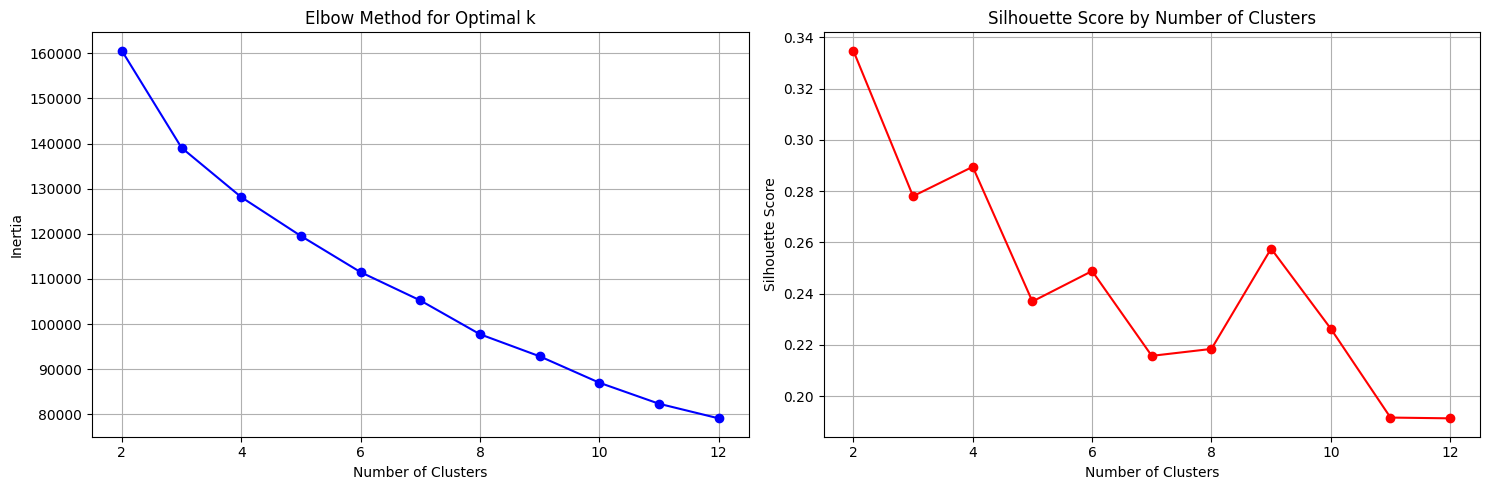

Recommended number of clusters: 2
Silhouette score: 0.335
Optimal number of clusters found: 2
Using different clustesr for testing...


In [13]:
# Find optimal number of clusters
print("finding optimal number of clusters...")
optimal_k, scores = analyzer.find_optimal_clusters(max_clusters=12)
print(f"Optimal number of clusters found: {optimal_k}")
print("Using different clustesr for testing...")


Testing with 5 clusters

In [14]:
print(f"\n=== FINAL CLUSTERING WITH 5 SEGMENTS ===")
cluster_labels, cluster_centers = analyzer.perform_clustering(n_clusters=5)
print("Analyzing cluster characteristics...")
cluster_summary, interpretations = analyzer.analyze_clusters()


=== FINAL CLUSTERING WITH 5 SEGMENTS ===
Features for clustering: ['SALES_ORDER_NO_nunique', 'SKU_nunique', 'RETURN_RATE', 'RETURN_RATIO', 'ITEMS_RETURNED_COUNT', 'RETURN_PRODUCT_VARIETY', 'CUSTOMER_LIFETIME_DAYS', 'RECENT_ORDERS', 'RECENT_RETURNS', 'SALES_QTY_mean', 'AVG_DAYS_TO_RETURN', 'RETURN_TIMING_SPREAD', 'AVG_RETURNS_PER_ORDER', 'RETURN_FREQUENCY_RATIO', 'AVG_RETURN_INTENSITY']
Number of features: 15
Using existing scaler parameters
Scaled data shape: (12709, 15)
Analyzing cluster characteristics...
=== CLUSTER ANALYSIS ===
         AVG_ORDERS  CUSTOMER_COUNT  AVG_RETURN_RATE  AVG_RETURN_RATIO  \
CLUSTER                                                                  
0            15.531            3220            0.522             0.517   
1            23.130            7409            0.151             0.145   
2            65.685            1614            0.352             0.344   
3            10.668             337            0.659             0.649   
4           219.1

In [15]:
cluster_summary.to_csv('cluster_summary.csv', index=False)

visualizing clusters...


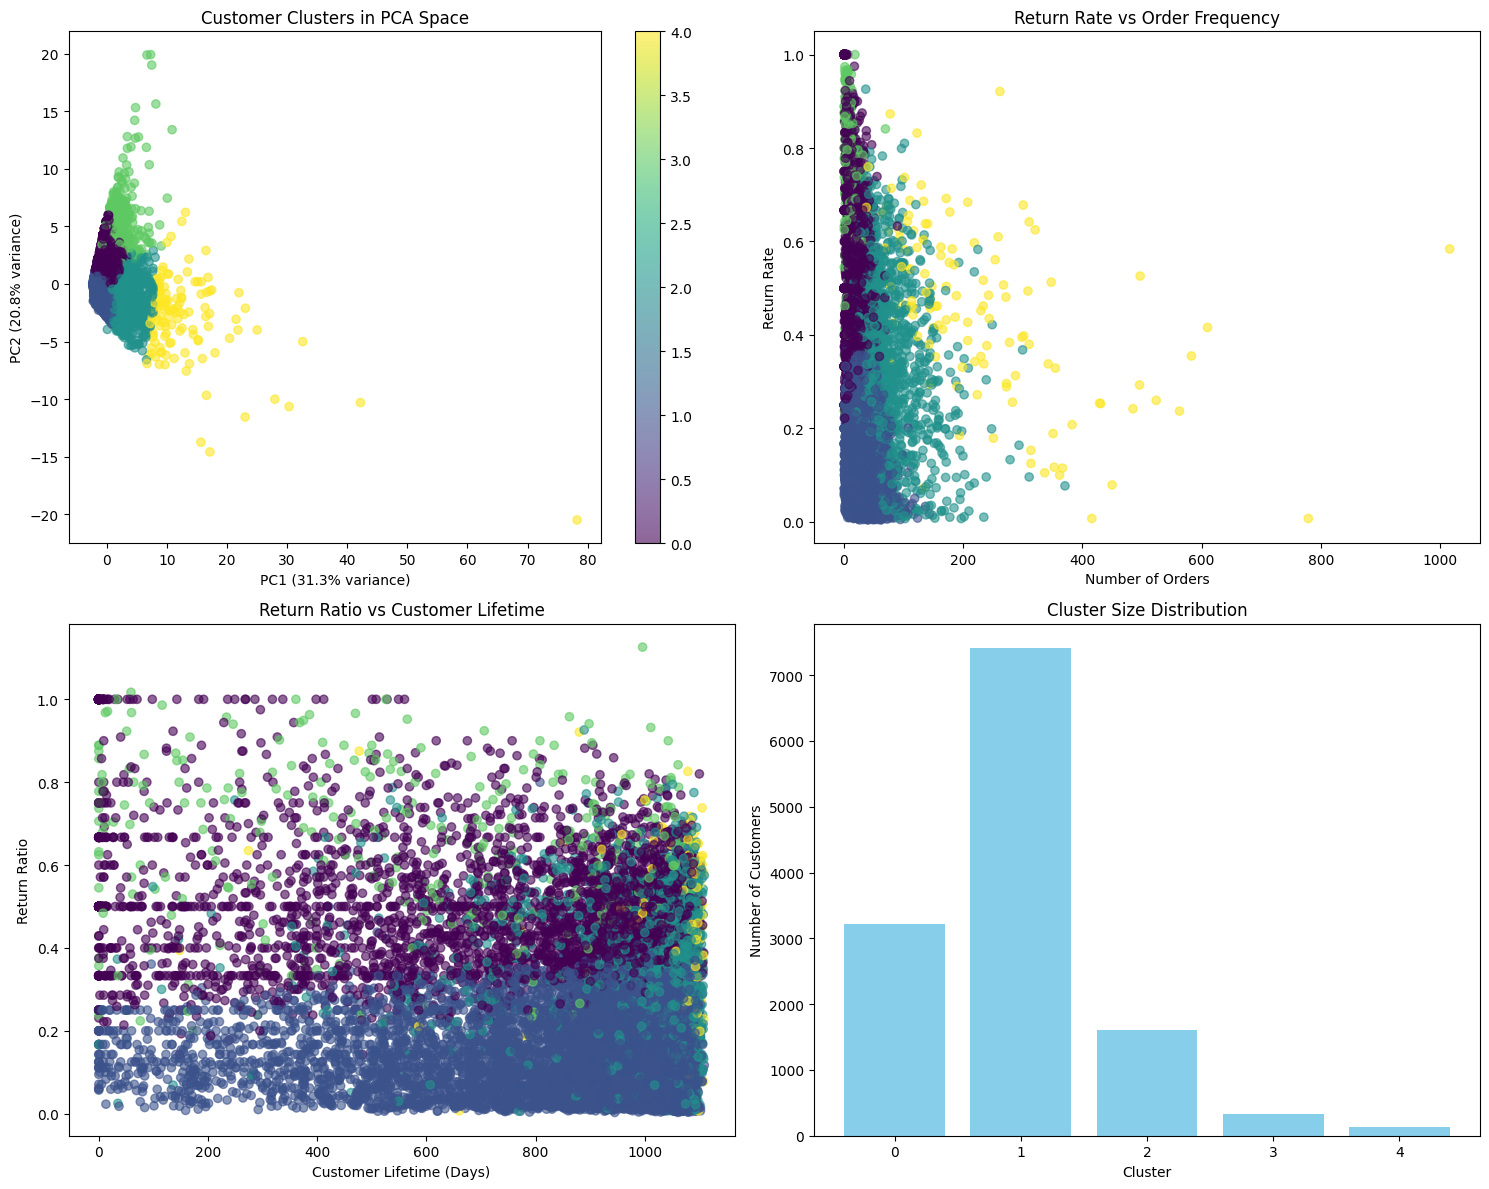

Clusters visualized successfully.


In [16]:
# Visualize
print("visualizing clusters...")
analyzer.visualize_clusters()
print("Clusters visualized successfully.")


In [17]:
# Export results
print("exporting results...")
results = analyzer.export_results()
print("Results exported successfully.")


exporting results...
=== CLUSTER ANALYSIS ===
         AVG_ORDERS  CUSTOMER_COUNT  AVG_RETURN_RATE  AVG_RETURN_RATIO  \
CLUSTER                                                                  
0            15.531            3220            0.522             0.517   
1            23.130            7409            0.151             0.145   
2            65.685            1614            0.352             0.344   
3            10.668             337            0.659             0.649   
4           219.178             129            0.462             0.451   

         AVG_ITEMS_RETURNED  AVG_LIFETIME_DAYS  AVG_RECENT_ORDERS  \
CLUSTER                                                             
0                    20.894            651.133              1.425   
1                     8.373            848.437              1.850   
2                    55.401            995.015              6.499   
3                    50.617            589.027              1.148   
4                   2

In [ ]:
# High-risk customers (for retention campaigns)
high_risk_clusters = [i for i, info in interpretations.items() 
    if 'HIGH RISK' in info['type'] or 'CHURN RISK' in info['type']]

if high_risk_clusters:
    print(f"High-risk clusters identified: {high_risk_clusters}")
    high_risk_customers = []
    for cluster_id in high_risk_clusters:
        customers = analyzer.get_cluster_customers(cluster_id)
        high_risk_customers.extend(customers)
    
    print(f"Total high-risk customers: {len(high_risk_customers)}")
    
    # Save high-risk customer list
    pd.DataFrame({'CUSTOMER_EMAILID': high_risk_customers}).to_csv('high_risk_customers.csv', index=False)
    print("High-risk customer list saved to 'high_risk_customers.csv'")

# Loyal customers (for rewards programs)
loyal_clusters = [i for i, info in interpretations.items() 
    if 'LOYAL' in info['type']]

if loyal_clusters:
    print(f"\nLoyal clusters identified: {loyal_clusters}")
    loyal_customers = []
    for cluster_id in loyal_clusters:
        customers = analyzer.get_cluster_customers(cluster_id)
        loyal_customers.extend(customers)
    
    print(f"Total loyal customers: {len(loyal_customers)}")
    
    # Save loyal customer list
    pd.DataFrame({'CUSTOMER_EMAILID': loyal_customers}).to_csv('loyal_customers.csv', index=False)
    print("Loyal customer list saved to 'loyal_customers.csv'")
print("\n" + "="*50)
print("MARKETING CAMPAIGN RECOMMENDATIONS")
print("="*50)

for cluster_id, info in interpretations.items():
    customers = analyzer.get_cluster_customers(cluster_id)
    print(f"\n📊 {info['type']}")
    print(f"   👥 Customers: {info['customers']}")
    print(f"   🎯 Action: {info['action']}")
    print(f"   📧 Sample emails: {customers[:3] if len(customers) >= 3 else customers}")

# Cell 12: Additional Analysis (Optional)
# =======================================
# You can add custom analysis here based on your specific business needs

# Example: Analyze return patterns by product category
if 'Q_CLS_ID' in df.columns:
    print("\n" + "="*40)
    print("PRODUCT CATEGORY ANALYSIS")
    print("="*40)

    # Get the cluster assignments
    customer_clusters = analyzer.customer_features[['CLUSTER']].reset_index()
    
    # Merge with original data to add cluster information
    df_with_clusters = df.merge(customer_clusters, on='CUSTOMER_EMAILID', how='left')
    
    # Now analyze by cluster and category (only for customers with clusters)
    category_returns = df_with_clusters[df_with_clusters['CLUSTER'].notna()].groupby(['CLUSTER', 'Q_CLS_ID']).agg({
        'RETURN_QTY': 'sum',
        'CUSTOMER_EMAILID': 'nunique'
    }).round(2)

# Example: Time-based analysis
print("\n" + "="*40)
print("SEASONAL RETURN PATTERNS")
print("="*40)

df['ORDER_MONTH'] = pd.to_datetime(df['ORDER_DATE']).dt.month
df_with_clusters['ORDER_MONTH'] = pd.to_datetime(df_with_clusters['ORDER_DATE']).dt.month
monthly_returns = df_with_clusters[df_with_clusters['CLUSTER'].notna()].groupby(['CLUSTER', 'ORDER_MONTH'])['RETURN_QTY'].sum().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(monthly_returns, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('Return Quantities by Cluster and Month')
plt.xlabel('Month')
plt.ylabel('Cluster')
plt.show()

High-risk clusters identified: [0, 3, 4]
Total high-risk customers: 3686
High-risk customer list saved to 'high_risk_customers.csv'

MARKETING CAMPAIGN RECOMMENDATIONS

📊 HIGH RISK - Heavy Returners
   👥 Customers: 3220
   🎯 Action: Immediate retention intervention needed
   📧 Sample emails: ['trinahale1980@gmail.com', 'trinaise13@gmail.com', 'trinakiki2001@gmail.com']

📊 STANDARD - Balanced Customers
   👥 Customers: 7409
   🎯 Action: Standard marketing engagement
   📧 Sample emails: ['trinah2o@hotmail.com', 'trinajablonsky@yahoo.com', 'trinaleeroberts@yahoo.com']

📊 EXPLORERS - High Product Variety
   👥 Customers: 1614
   🎯 Action: Product discovery campaigns
   📧 Sample emails: ['trinamariner@gmail.com', 'trinette.johnston@gmail.com', 'trinette.kirby@gmail.com']

📊 HIGH RISK - Heavy Returners
   👥 Customers: 337
   🎯 Action: Immediate retention intervention needed
   📧 Sample emails: ['trinahebert@att.net', 'trinaphamelectronics@gmail.com', 'trinitygossettlee@icloud.com']

📊 HIGH RIS

KeyError: 'ORDER_MONTH'